In [1]:
import cv2
import pandas as pd
import torch
import numpy as np
from PIL import Image
from yolov5.models.experimental import attempt_load
from class_mapping import yolo_class_mapping
from perform_object import perform_object
from convert_data import collect_coordinates
from create_polygon import check_polylist

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")



### Check opencv version

In [2]:
print('opencv version: ', cv2.__version__)

opencv version:  4.8.0


### Load Model

In [3]:
device = torch.device('cpu')

# Load trained YOLOv5 model weights
yolo_weights_path = '/Users/bongeungu/Desktop/kfq/KFQ_TEAM01/yolo/models/yolov5m.pt'

yolo_model = attempt_load(yolo_weights_path, device=device)

Fusing layers... 
YOLOv5m summary: 369 layers, 21190557 parameters, 0 gradients


### Create polygon using road boundary coordinates data

       X1   Y1    X2   Y2 Class_Name
0     904  157  1236  339        car
1     411  389   974  752        car
2    1075  401  1699  701        car
3       0  301   190  593        car
4     725   97  1025  265        car
..    ...  ...   ...  ...        ...
686   843  608  1482  947        car
687   425  478   985  771        car
688   118  380   634  644        car
689     0  297   324  528        car
690     0  266    50  411        car

[691 rows x 5 columns]
coodrinates count: 691


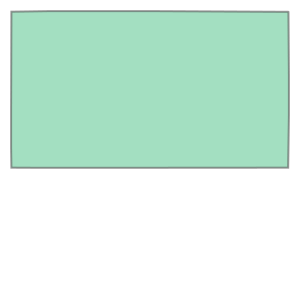

In [5]:
# Initialize webcam
cap = cv2.VideoCapture(0)

columns = ['X1', 'Y1', 'X2', 'Y2', 'Class_Name']
road_coordinates = pd.DataFrame(columns=columns)
sidewalk_coordinates = pd.DataFrame(columns=columns)

for i in range(400):
    ret, frame = cap.read()
    
    image = Image.fromarray(frame)
    image = image.resize((640,640))
    image_tensor = torch.from_numpy(np.array(image)).float().permute(2, 0, 1) / 255.0
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    results = perform_object(image_tensor, 0.65, yolo_model)
    road_coordinates, sidewalk_coordinates = collect_coordinates(results, frame, yolo_class_mapping, road_coordinates, sidewalk_coordinates)

cap.release()
print(road_coordinates)
print(f'coodrinates count: {len(road_coordinates)}')

# Create road boundary polygon using road coordinates data
polygon = check_polylist(road_coordinates)
polygon